In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, accuracy_score, f1_score, auc,classification_report
from scipy.stats import ks_2samp

from sklearn.preprocessing import label_binarize,OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder
from itertools import cycle

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
import shap

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA

import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd

def load_data(path):
    df = pd.read_csv(path)
    # arham check this later
    # original = pd.read_csv('/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv')
    # split to train test
    train_df, test_df = train_test_split(df, test_size=0.35, random_state=42)
    train_df = train_df.drop(['id'], axis=1).drop_duplicates().reset_index(drop=True)
    test_df = test_df.drop(['id'], axis=1).drop_duplicates().reset_index(drop=True)
    return train_df, test_df

In [2]:

path = '/Users/arham/Downloads/Projects/01-Dataset/01-Data-for-model-building/train.csv'
train, test = load_data(path)

In [3]:
target = 'NObeyesdad'
num_col = []
cat_col = []

for i in train.columns.drop([target]) : 
    
    if train[i].dtype == 'object' : 
        cat_col.append(i)
        
    else : 
        num_col.append(i)

print("Numerical Columns : ", *num_col,"\n",sep="\n")
print("Categorical Columns : ", *cat_col,sep="\n")


Numerical Columns : 
Age
Height
Weight
FCVC
NCP
CH2O
FAF
TUE


Categorical Columns : 
Gender
family_history_with_overweight
FAVC
CAEC
SMOKE
SCC
CALC
MTRANS


In [4]:
basic_EDA = True

if basic_EDA : 
    print("\n","="*25,"Train","="*25)
    display(train.describe().T)
    display(train.info())
    
    print("\n","="*25,"Test","="*25)
    display(test.describe().T)
    display(test.info())


 ========================= Train =========================


count       mean        std    min        25%        50%  \
Age     13492.0  23.880276   5.724591  14.00  20.000000  22.846357   
Height  13492.0   1.699843   0.087429   1.45   1.631305   1.700000   
Weight  13492.0  87.806249  26.290492  39.00  66.000000  84.000000   
FCVC    13492.0   2.445200   0.532131   1.00   2.000000   2.390173   
NCP     13492.0   2.762764   0.703167   1.00   3.000000   3.000000   
CH2O    13492.0   2.027960   0.607319   1.00   1.791286   2.000000   
FAF     13492.0   0.979845   0.840058   0.00   0.005939   1.000000   
TUE     13492.0   0.619187   0.605093   0.00   0.000000   0.568668   

               75%         max  
Age      26.000000   61.000000  
Height    1.761583    1.975663  
Weight  111.555967  165.057269  
FCVC      3.000000    3.000000  
NCP       3.000000    4.000000  
CH2O      2.531984    3.000000  
FAF       1.590255    3.000000  
TUE       1.000000    2.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13492 entries, 0 to 13491
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          13492 non-null  object 
 1   Age                             13492 non-null  float64
 2   Height                          13492 non-null  float64
 3   Weight                          13492 non-null  float64
 4   family_history_with_overweight  13492 non-null  object 
 5   FAVC                            13492 non-null  object 
 6   FCVC                            13492 non-null  float64
 7   NCP                             13492 non-null  float64
 8   CAEC                            13492 non-null  object 
 9   SMOKE                           13492 non-null  object 
 10  CH2O                            13492 non-null  float64
 11  SCC                             13492 non-null  object 
 12  FAF                             

None


 ========================= Test =========================


count       mean        std        min        25%        50%  \
Age     7266.0  23.770368   5.619325  14.000000  20.000000  22.699880   
Height  7266.0   1.700992   0.087094   1.450000   1.632896   1.700000   
Weight  7266.0  88.039138  26.544974  39.101805  66.000000  84.706568   
FCVC    7266.0   2.447225   0.535266   1.000000   2.000000   2.426596   
NCP     7266.0   2.758674   0.709497   1.000000   3.000000   3.000000   
CH2O    7266.0   2.032125   0.610625   1.000000   1.796257   2.000000   
FAF     7266.0   0.985277   0.835079   0.000000   0.012200   1.000000   
TUE     7266.0   0.612243   0.596556   0.000000   0.000000   0.583145   

               75%         max  
Age      26.000000   61.000000  
Height    1.763029    1.975663  
Weight  111.820949  165.057269  
FCVC      3.000000    3.000000  
NCP       3.000000    4.000000  
CH2O      2.555189    3.000000  
FAF       1.586525    3.000000  
TUE       1.000000    2.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7266 entries, 0 to 7265
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          7266 non-null   object 
 1   Age                             7266 non-null   float64
 2   Height                          7266 non-null   float64
 3   Weight                          7266 non-null   float64
 4   family_history_with_overweight  7266 non-null   object 
 5   FAVC                            7266 non-null   object 
 6   FCVC                            7266 non-null   float64
 7   NCP                             7266 non-null   float64
 8   CAEC                            7266 non-null   object 
 9   SMOKE                           7266 non-null   object 
 10  CH2O                            7266 non-null   float64
 11  SCC                             7266 non-null   object 
 12  FAF                             72

None

<Figure size 2000x700 with 0 Axes>

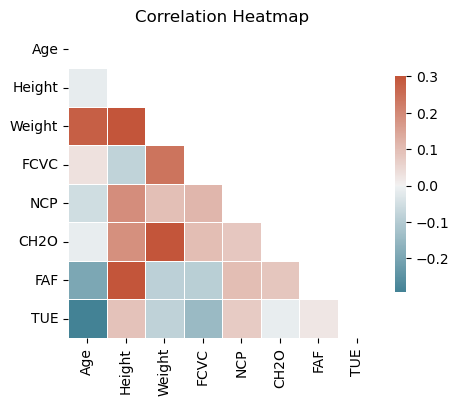

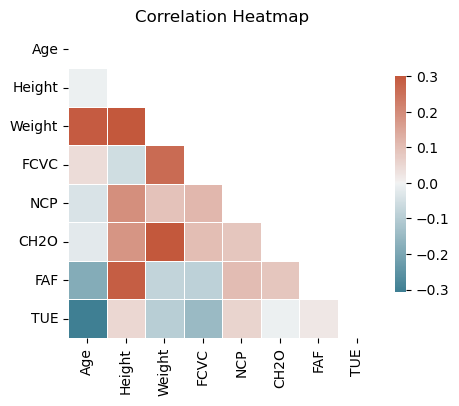

In [5]:
def corr_heat_map(df,scale=1) :
    # Calculate the correlation matrix
    correlation_matrix = df.corr()

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    # Set up the matplotlib figure
    plt.figure(figsize=(10//scale, 8//scale))

    # Define a custom color palette
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": 0.7})

    plt.title('Correlation Heatmap')

plt.figure(figsize=(20,7))

corr_heat_map(train[num_col],2)
corr_heat_map(test[num_col],2)

plt.show()


<Figure size 3000x3000 with 0 Axes>

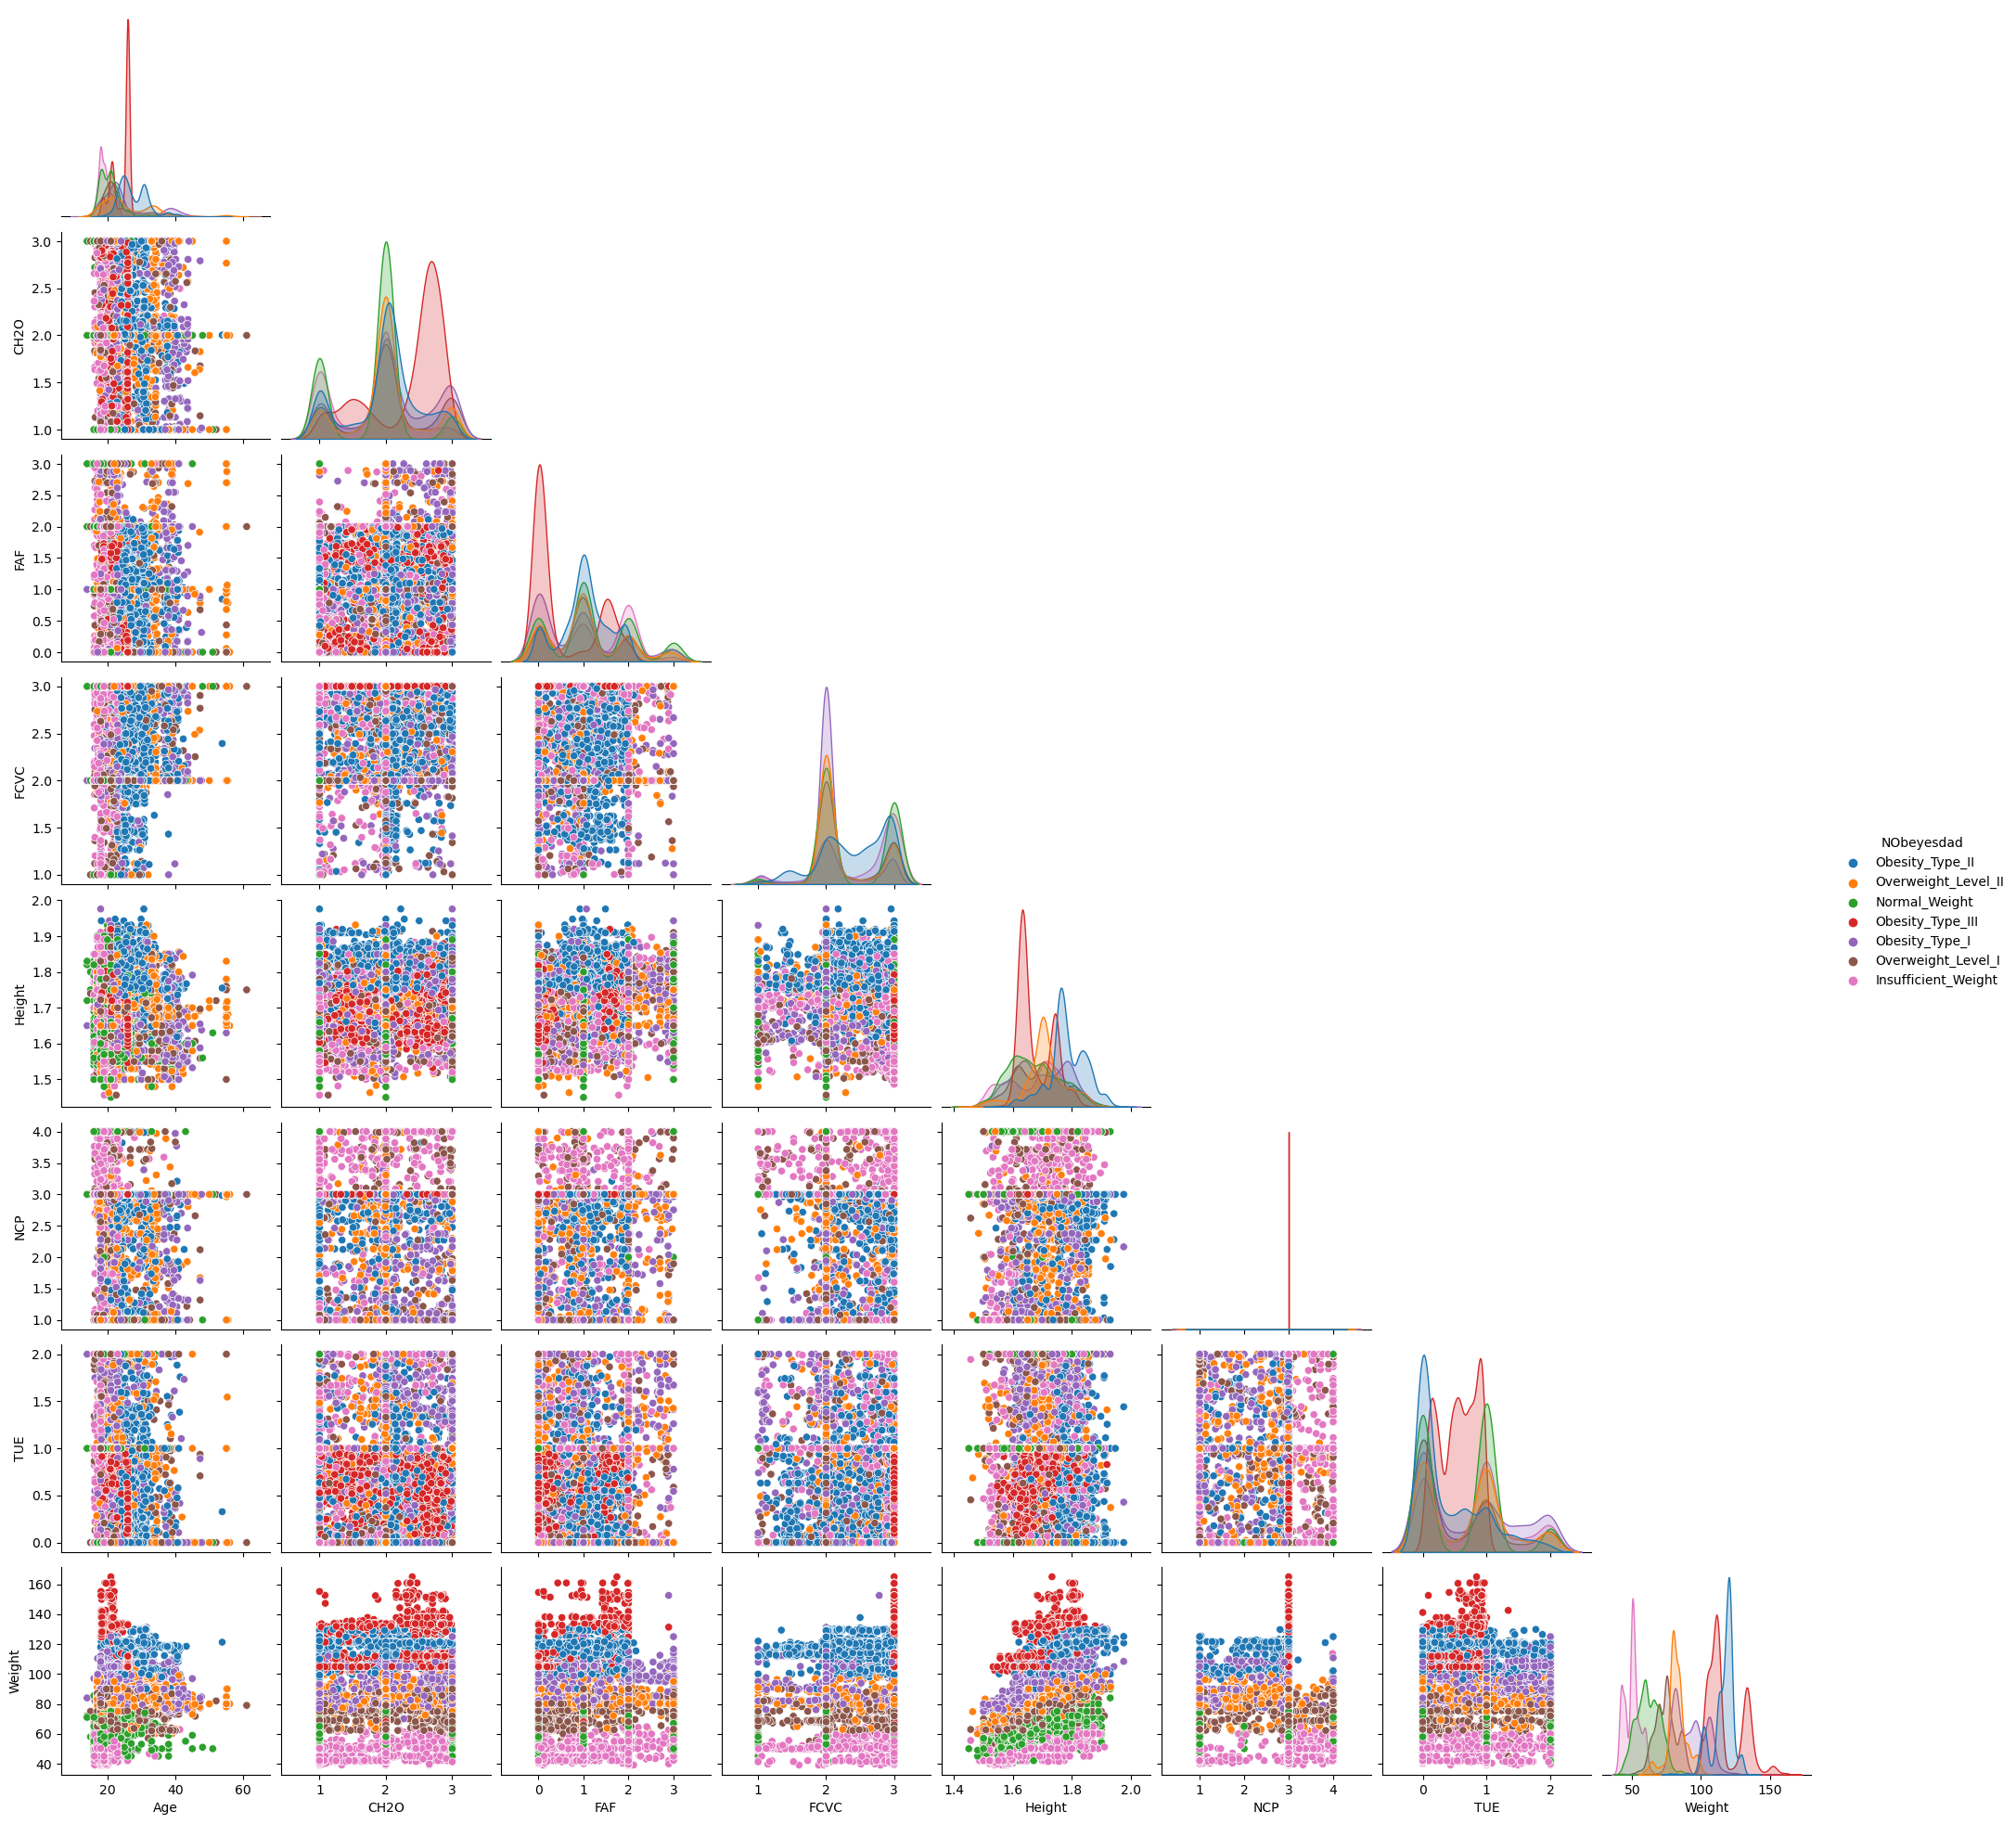

In [6]:
plt.figure(figsize=(30,30))
temp=num_col.copy()
temp.extend([target])
sns.pairplot(train[sorted(temp)],hue=target, corner=True)
plt.show()

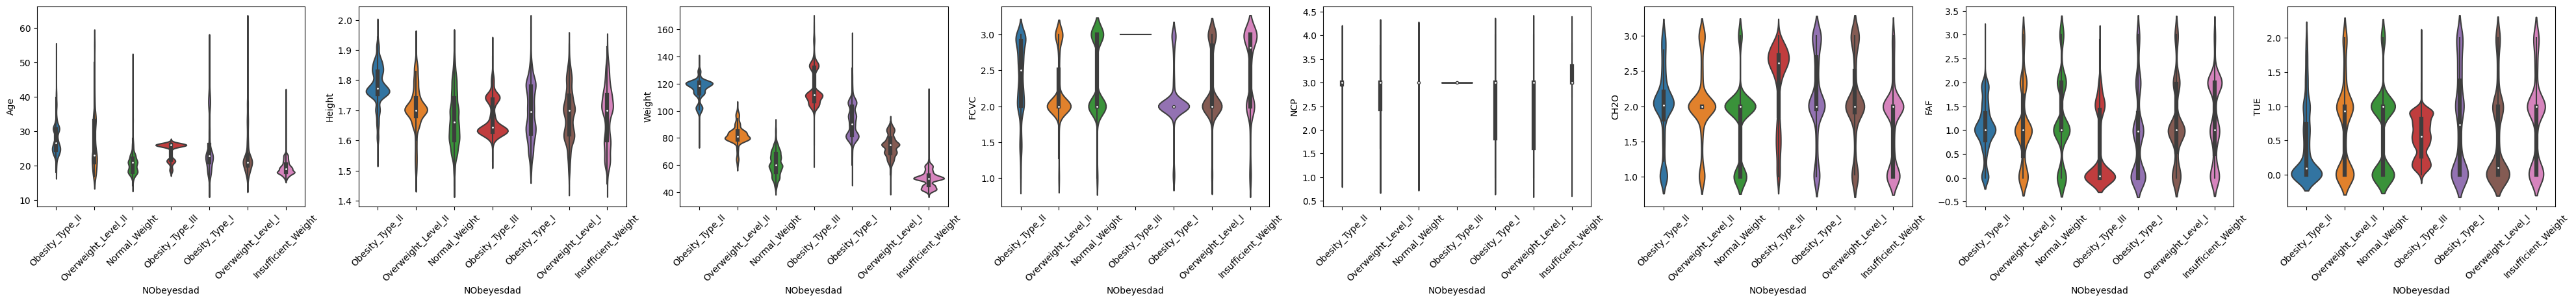

In [7]:
plt.figure(figsize=(50,4))

x=1
for i in num_col : 
    
    plt.subplot(1,8,x)
    sns.violinplot(
        data=train,
        x=target,
        y=i
    )
    plt.xticks(rotation=45)
    x+=1

plt.show()

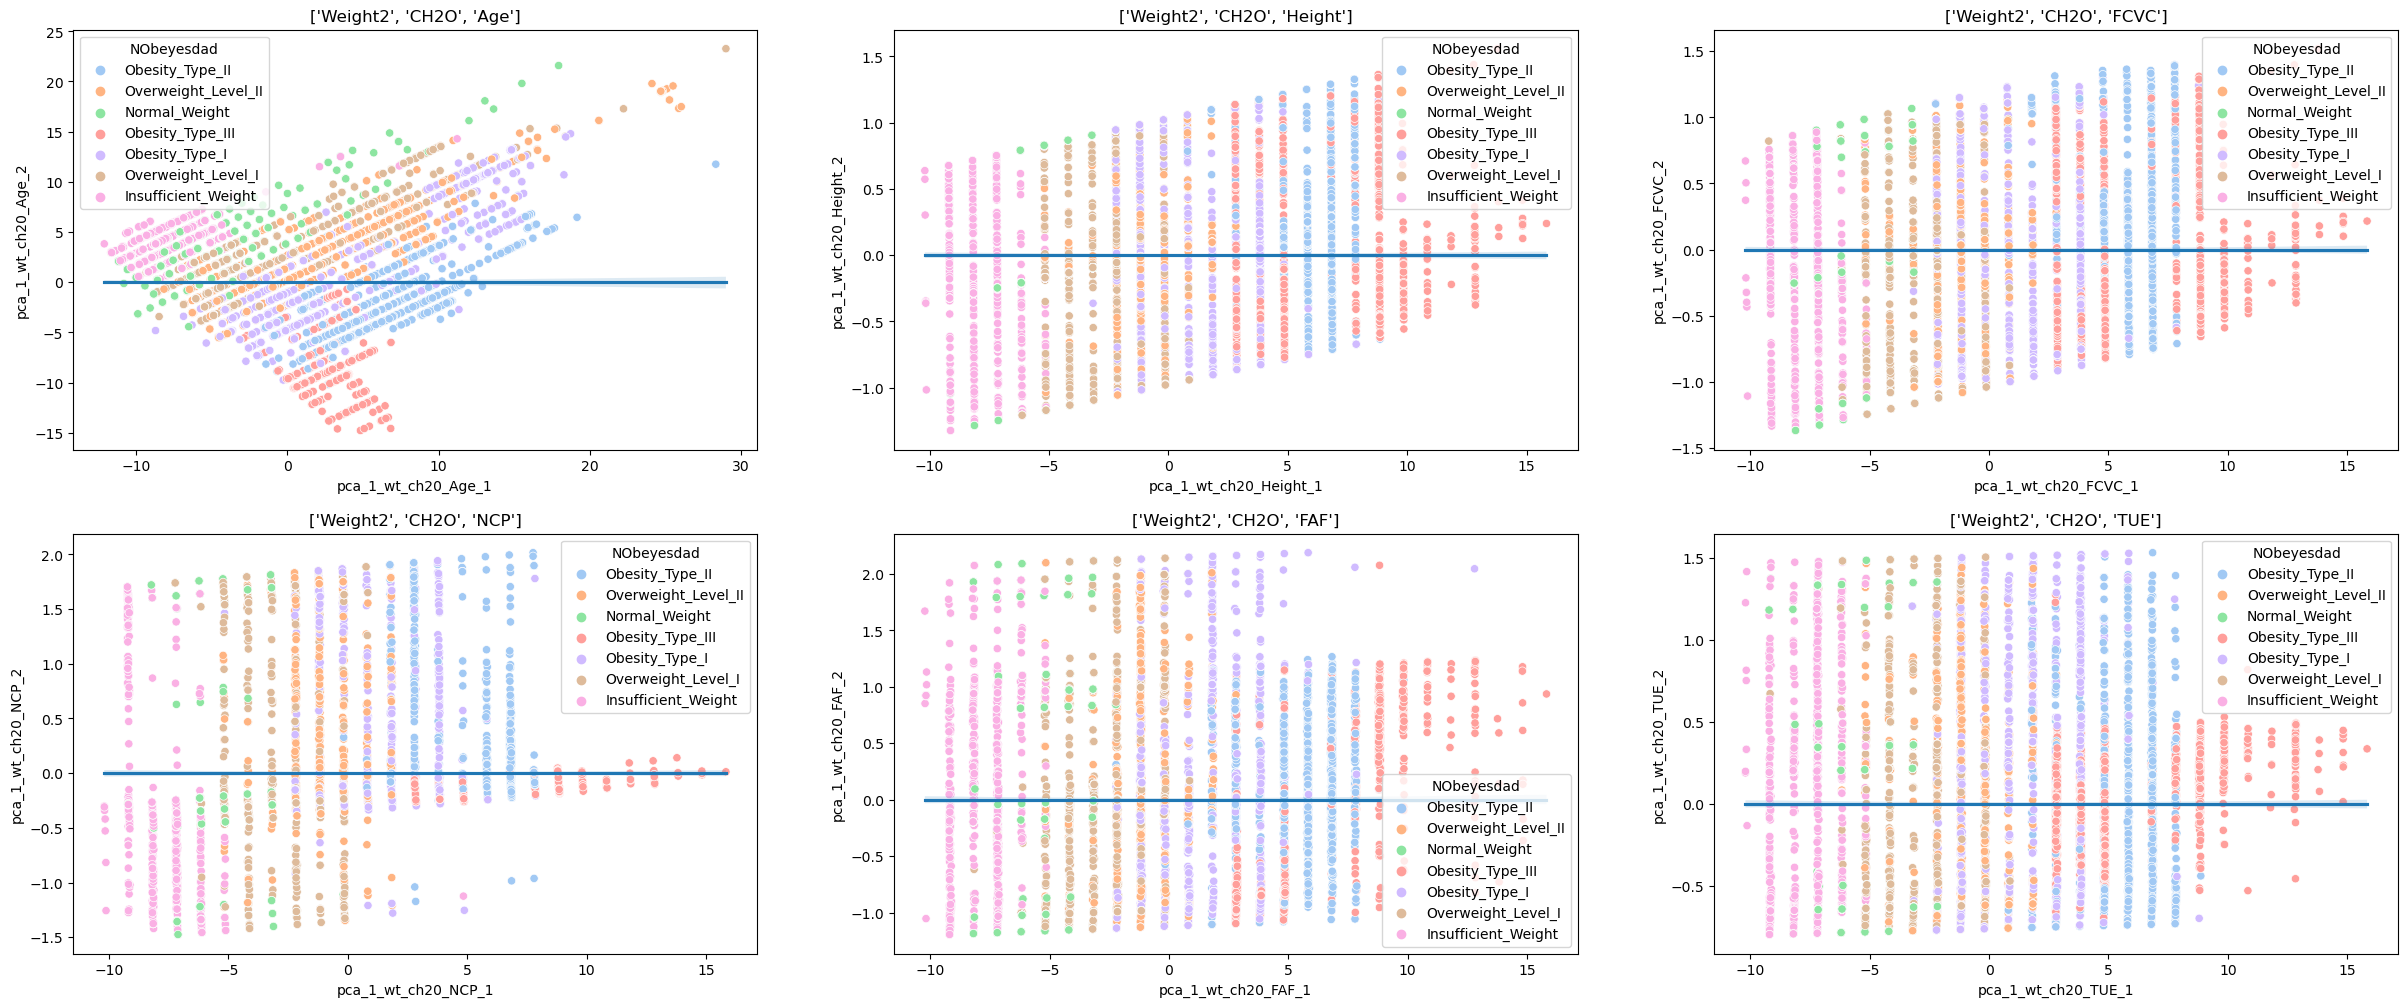

In [8]:
temp = train.copy()
plt.figure(figsize=(30,12))
plot_num = 1
for i in ['Age', 'Height', 'FCVC', 'NCP', 'FAF', 'TUE'] :
    
    sc = StandardScaler()
    p =  PCA(n_components=2,random_state=42)
    temp['Weight2'] = temp['Weight']//5
    
    x=['Weight2','CH2O',i]
    temp[['pca_1_wt_ch20_'+i+"_1",'pca_1_wt_ch20_'+i+"_2"]] = p.fit_transform(temp[x])
    
    plt.subplot(2,3,plot_num)
    plt.title(x)
    sns.scatterplot(x= temp['pca_1_wt_ch20_'+i+"_1"],
                    y=temp['pca_1_wt_ch20_'+i+"_2"],
                    hue=temp[target],
                    palette = 'pastel',
                    legend = 'full'
    )
    sns.regplot(x= temp['pca_1_wt_ch20_'+i+"_1"],
                y=temp['pca_1_wt_ch20_'+i+"_2"],
                scatter=False
    )
    
    plot_num+=1

plt.show()

Feature Engineering

In [9]:
train = pd.get_dummies(train,
                       columns=cat_col)
test = pd.get_dummies(test, 
                      columns=cat_col)
train.head()

Age    Height      Weight      FCVC       NCP      CH2O       FAF  \
0  23.586058  1.750000  119.434645  1.655684  3.000000  2.000000  1.097983   
1  24.565628  1.769328   85.079589  1.979944  3.566082  2.000000  0.000000   
2  22.000000  1.650000   60.000000  3.000000  3.000000  2.000000  3.000000   
3  25.930376  1.610086  104.954291  3.000000  3.000000  2.411582  0.001297   
4  33.000000  1.700000   97.000000  2.000000  3.000000  2.000000  3.000000   

        TUE           NObeyesdad  Gender_Female  ...  SCC_no  SCC_yes  \
0  0.738935      Obesity_Type_II          False  ...    True    False   
1  1.944675  Overweight_Level_II          False  ...    True    False   
2  0.000000        Normal_Weight           True  ...    True    False   
3  0.656491     Obesity_Type_III           True  ...    True    False   
4  0.000000       Obesity_Type_I          False  ...    True    False   

   CALC_Frequently  CALC_Sometimes  CALC_no  MTRANS_Automobile  MTRANS_Bike  \
0            False            True    False              False        False   
1            False            True    False              False        False   
2            False           False     True              False        False   
3            False            True    False              False        False   
4             True           False    False               True        False   

   MTRANS_Motorbike  MTRANS_Public_Transportation  MTRANS_Walking  
0             False                          True           False  
1             False                          True           False  
2             False                         False            True  
3             False                          True           False  
4             False                         False           False  

[5 rows x 31 columns]

In [10]:
target = 'NObeyesdad'

le = LabelEncoder()
train['NObeyesdad'] = le.fit_transform(train['NObeyesdad'])

In [12]:
X_train, X_val, y_train, y_val = train_test_split(train.drop([target],axis=1),train[target],test_size=0.2,random_state=42)

In [13]:
X_train.shape , y_train.shape, X_val.shape, y_val.shape 


((10793, 30), (10793,), (2699, 30), (2699,))

In [17]:
X_test = test.copy().drop(['id'],axis=1)

KeyError: "['id'] not found in axis"

Model

In [18]:
import optuna
ran_optuna = False 

In [19]:
def optimization_function(trial) : 
    
    lgbParams = {
        'num_class': 7,
        'random_state': 42,
        'metric': 'multi_logloss',
        "boosting_type": "gbdt",
        'objective': 'multiclass',
        
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 400, 600),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-1, 10.0),
        'max_depth': trial.suggest_int('max_depth', 6, 20),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
    }
    
    lgb_model=lgb.LGBMClassifier(**lgbParams)
    
#     skf = StratifiedKFold(n_splits=5,shuffle=False, random_state=None)
#     accuracy = cross_val_score(lgb_model,X_train,y_train, cv=skf,scoring='accuracy')
#     print("="*50,'\nValidation Accuracy:', accuracy.mean())

    lgb_model.fit(X_train,y_train)
    
    acc = accuracy_score(y_val,lgb_model.predict(X_val))
    
    return acc

In [ ]:
if ran_optuna : 

    print('Number of finished trials:', len(study.trials))

    print('Best trial:', study.best_trial.params)

    optuna.visualization.plot_param_importances(study)

    study.trials_dataframe().sort_values('value',ascending=False)

    optuna.visualization.plot_slice(study)

# 100 trials 
# {'objective': 'multiclassova', 'learning_rate': 0.04641200998070569, 'n_estimators': 587, 'reg_alpha': 0.0065043557057678746, 'reg_lambda': 4.460933310544669, 'max_depth': 7, 'colsample_bytree': 0.6833315654013498, 'subsample': 0.8193986843950917, 'min_child_samples': 15}

In [20]:
if ran_optuna : 
    lgbParams = study.best_trial.params

else :
    
#     # 100- traials with PCA seed = None
#     lgbParams = {
#         'objective': 'multiclassova', 
#         'learning_rate': 0.04641200998070569, 
#         'n_estimators': 587, 
#         'reg_alpha': 0.0065043557057678746, 
#         'reg_lambda': 4.460933310544669, 
#         'max_depth': 7, 'colsample_bytree': 0.6833315654013498, 
#         'subsample': 0.8193986843950917, 
#         'min_child_samples': 15
#     }
    
    
    # Moaz HyperParams
    lgbParams = {
        "objective": "multiclass",          # Objective function for the model
        "metric": "multi_logloss",          # Evaluation metric
        "verbosity": -1,                    # Verbosity level (-1 for silent)
        "boosting_type": "gbdt",            # Gradient boosting type
        "random_state": 42,       # Random state for reproducibility
        "num_class": 7,                     # Number of classes in the dataset
        'learning_rate': 0.030962211546832760,  # Learning rate for gradient boosting
        'n_estimators': 500,                # Number of boosting iterations
        'lambda_l1': 0.009667446568254372,  # L1 regularization term
        'lambda_l2': 0.04018641437301800,   # L2 regularization term
        'max_depth': 10,                    # Maximum depth of the trees
        'colsample_bytree': 0.40977129346872643,  # Fraction of features to consider for each tree
        'subsample': 0.9535797422450176,    # Fraction of samples to consider for each boosting iteration
        'min_child_samples': 26             # Minimum number of data needed in a leaf
    }

In [21]:
fixed_params = {
    'boosting_type': 'gbdt',
    'num_class': 7,
    'random_state': 42,
    'metric': 'multi_logloss',
}

In [22]:
for i in fixed_params.keys() : 

    lgbParams[i] = fixed_params[i]

In [23]:
lgbParams

{'objective': 'multiclass',
 'metric': 'multi_logloss',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'random_state': 42,
 'num_class': 7,
 'learning_rate': 0.03096221154683276,
 'n_estimators': 500,
 'lambda_l1': 0.009667446568254372,
 'lambda_l2': 0.040186414373018,
 'max_depth': 10,
 'colsample_bytree': 0.4097712934687264,
 'subsample': 0.9535797422450176,
 'min_child_samples': 26}

In [24]:
lgb_model_final = lgb.LGBMClassifier(**lgbParams)

In [26]:
lgb_model_final = lgb_model_final.fit(X_train, y_train)

In [27]:
y_pred = lgb_model_final.predict(X_val)

In [28]:
accuracy_score(y_val, y_pred) 

0.9058910707669507

In [29]:
y_pred_proba = lgb_model_final.predict_proba(X_val)

In [30]:
X_val = pd.concat([X_val.reset_index(),pd.DataFrame({'actual':le.inverse_transform(y_val),'guess':le.inverse_transform(y_pred)})],axis=1)
X_val['dummy'] = 1
X_val.pivot_table(index='actual',columns='guess',values='dummy',aggfunc='sum')

guess                Insufficient_Weight  Normal_Weight  Obesity_Type_I  \
actual                                                                    
Insufficient_Weight                291.0           25.0             NaN   
Normal_Weight                       16.0          340.0             1.0   
Obesity_Type_I                       NaN            NaN           368.0   
Obesity_Type_II                      NaN            NaN             8.0   
Obesity_Type_III                     NaN            1.0             1.0   
Overweight_Level_I                   3.0           28.0            10.0   
Overweight_Level_II                  NaN            4.0            24.0   

guess                Obesity_Type_II  Obesity_Type_III  Overweight_Level_I  \
actual                                                                       
Insufficient_Weight              NaN               NaN                 NaN   
Normal_Weight                    NaN               NaN                11.0   
Obesity_Type_I                  12.0               3.0                 8.0   
Obesity_Type_II                407.0               NaN                 NaN   
Obesity_Type_III                 NaN             504.0                 NaN   
Overweight_Level_I               NaN               NaN               258.0   
Overweight_Level_II              2.0               NaN                22.0   

guess                Overweight_Level_II  
actual                                    
Insufficient_Weight                  NaN  
Normal_Weight                        6.0  
Obesity_Type_I                      30.0  
Obesity_Type_II                      3.0  
Obesity_Type_III                     NaN  
Overweight_Level_I                  36.0  
Overweight_Level_II                277.0

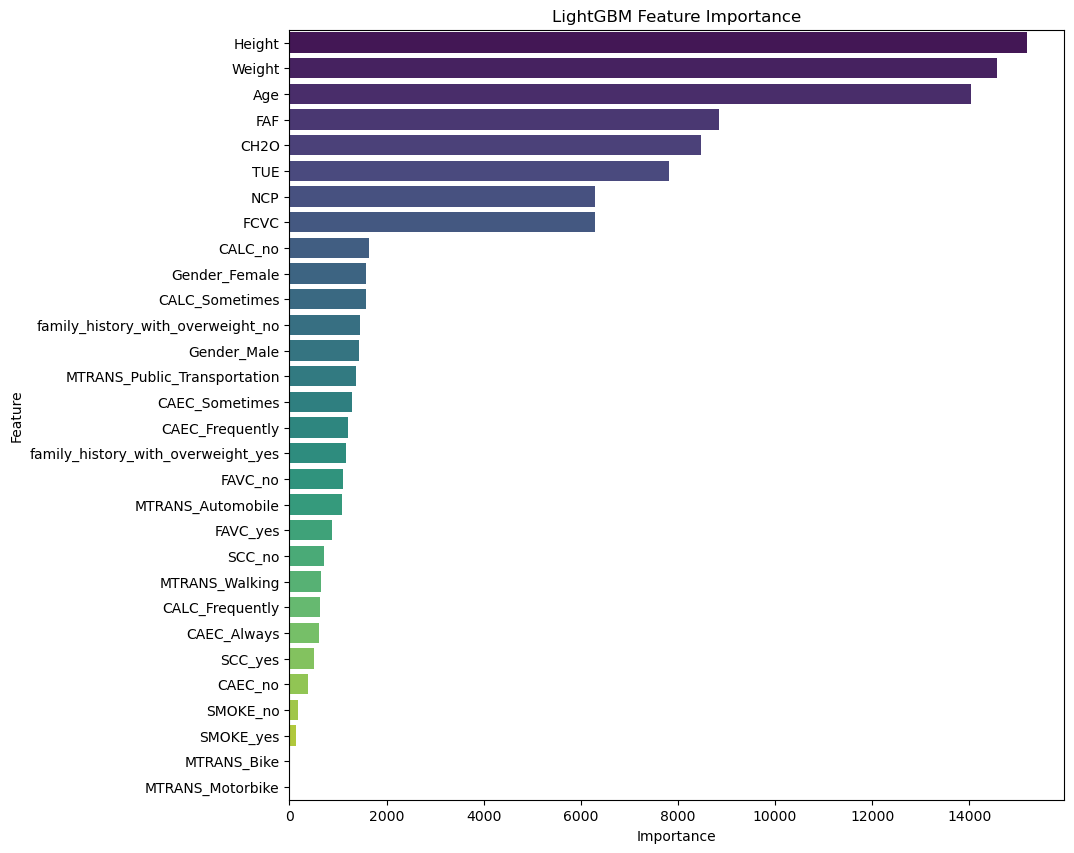

In [31]:
def plot_lgbm_feature_importance(model, feature_names=None, top_n=10, plot=True):

    # Get feature importance
    feature_importance = model.feature_importances_
    
    # Get feature names
    if feature_names is None:
        feature_names = model.feature_name()

    # Create DataFrame with feature names and importance scores
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Sort by importance and select top features
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)#.head(top_n)

    # Plot the feature importance
    if plot:
        plt.figure(figsize=(10, 10))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
        plt.title('LightGBM Feature Importance')
        plt.show()

    return feature_importance_df

feature_importance_df = plot_lgbm_feature_importance(lgb_model_final,feature_names=X_train.columns)

SHAP

In [32]:
import shap
def plot_shap_summary(model, X, plot_type='bar', plot=True):
    
    # Create a SHAP explainer object
    explainer = shap.TreeExplainer(model)

    # Calculate SHAP values
    shap_values = explainer.shap_values(X)

    return shap_values


In [33]:
shap_values = plot_shap_summary(lgb_model_final, pd.DataFrame(data=X_train,columns=X_train.columns))


['Insufficient_Weight']


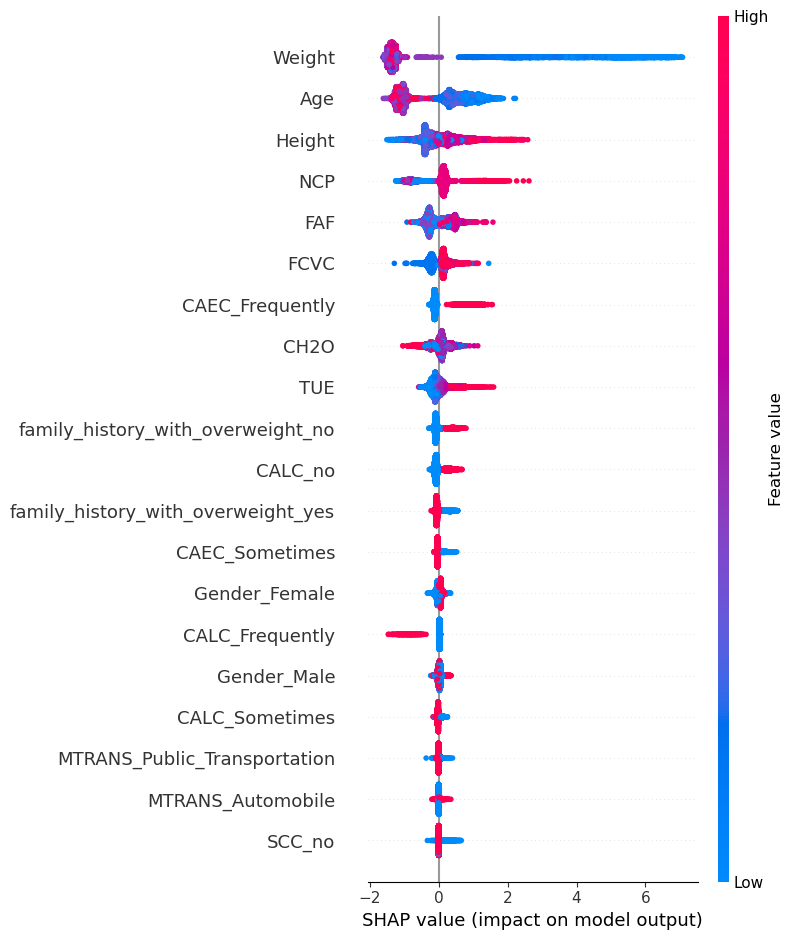

['Normal_Weight']


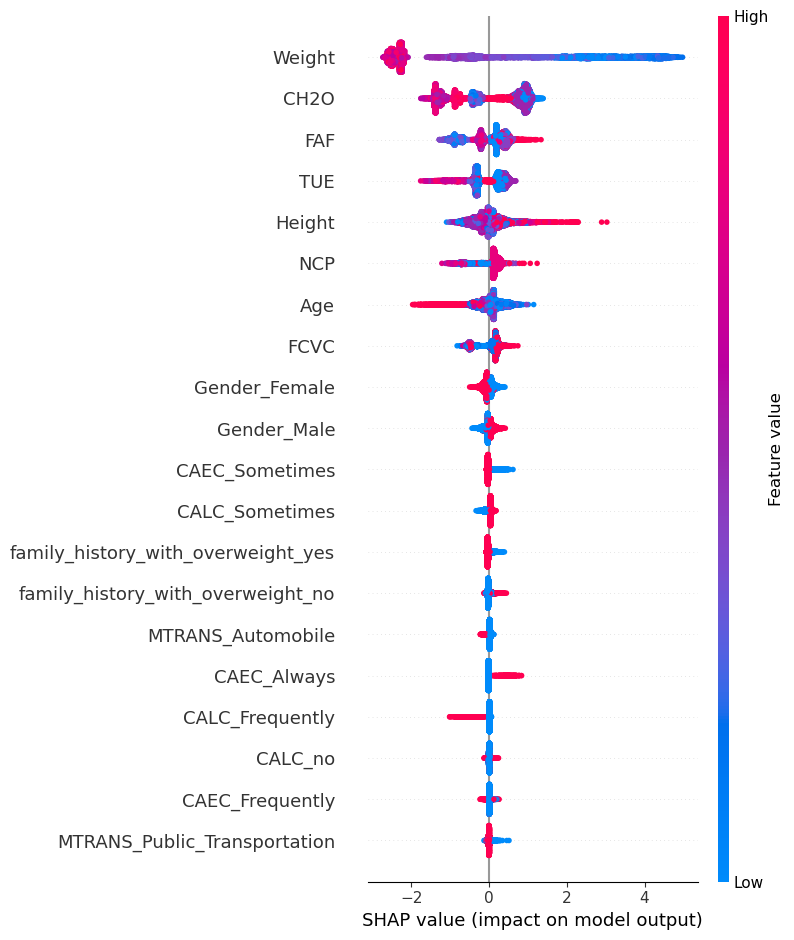

['Obesity_Type_I']


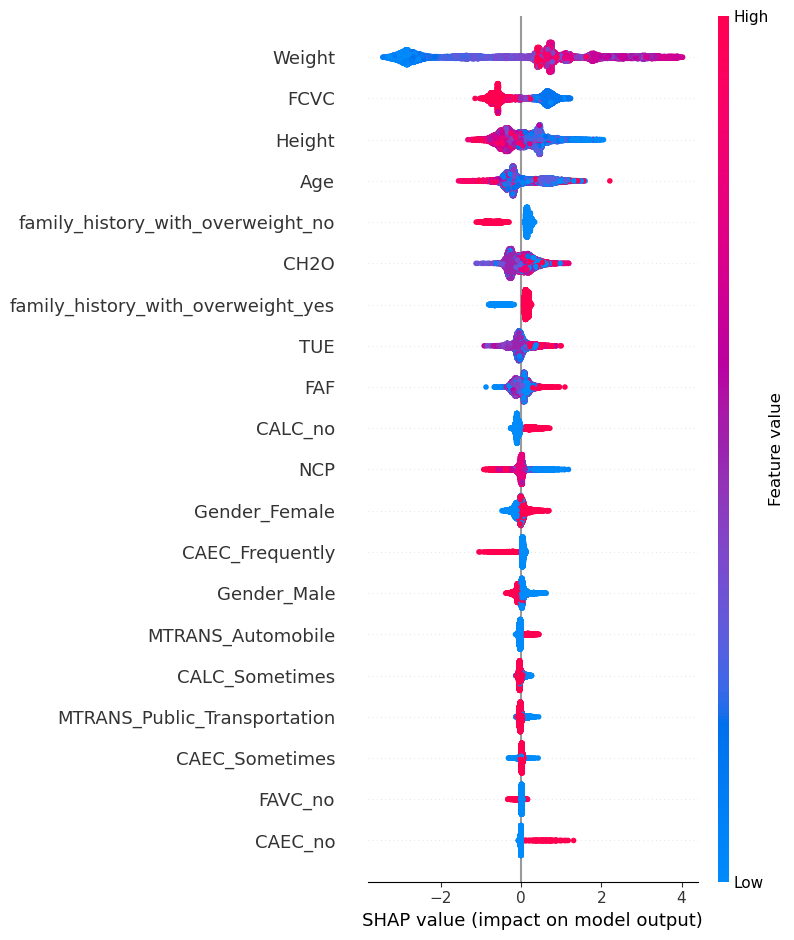

['Obesity_Type_II']


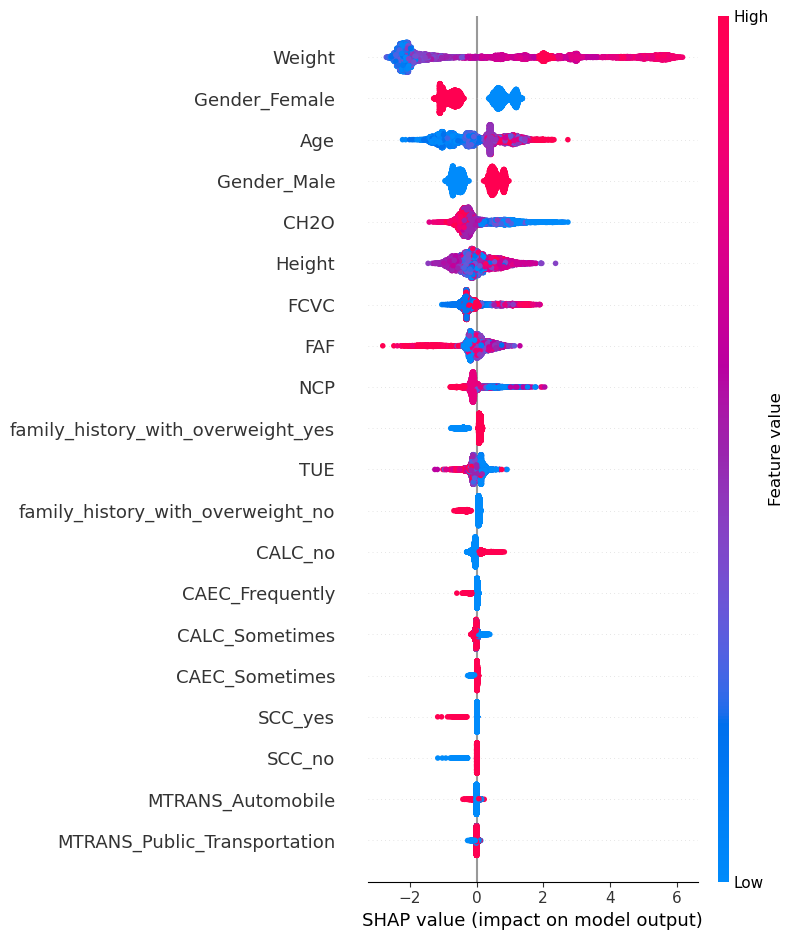

['Obesity_Type_III']


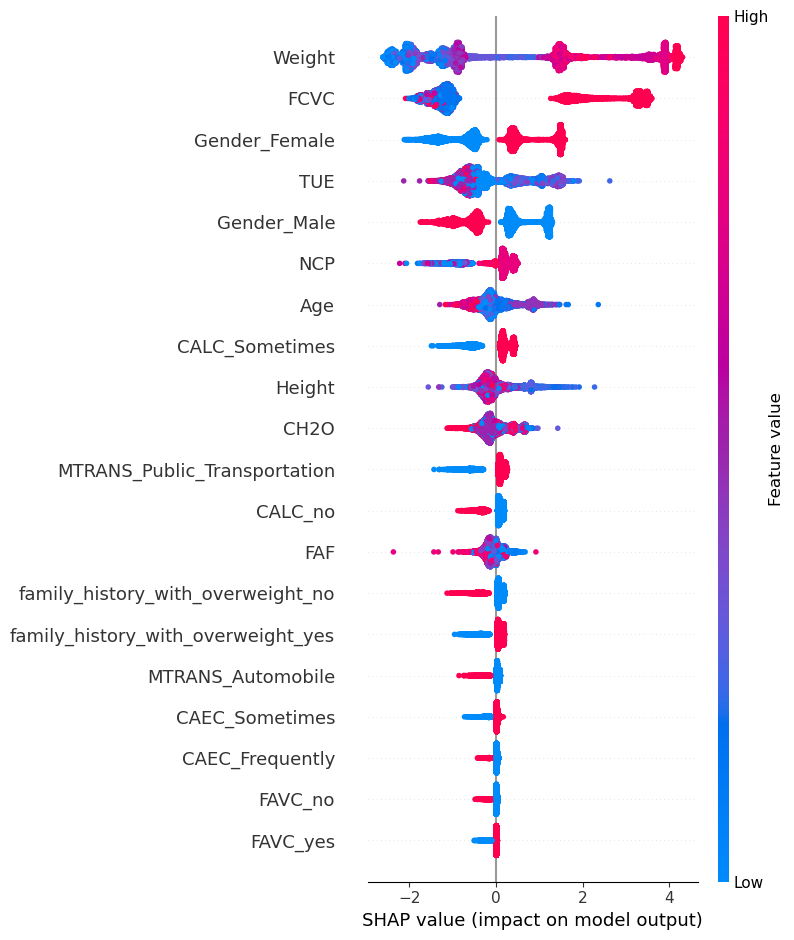

['Overweight_Level_I']


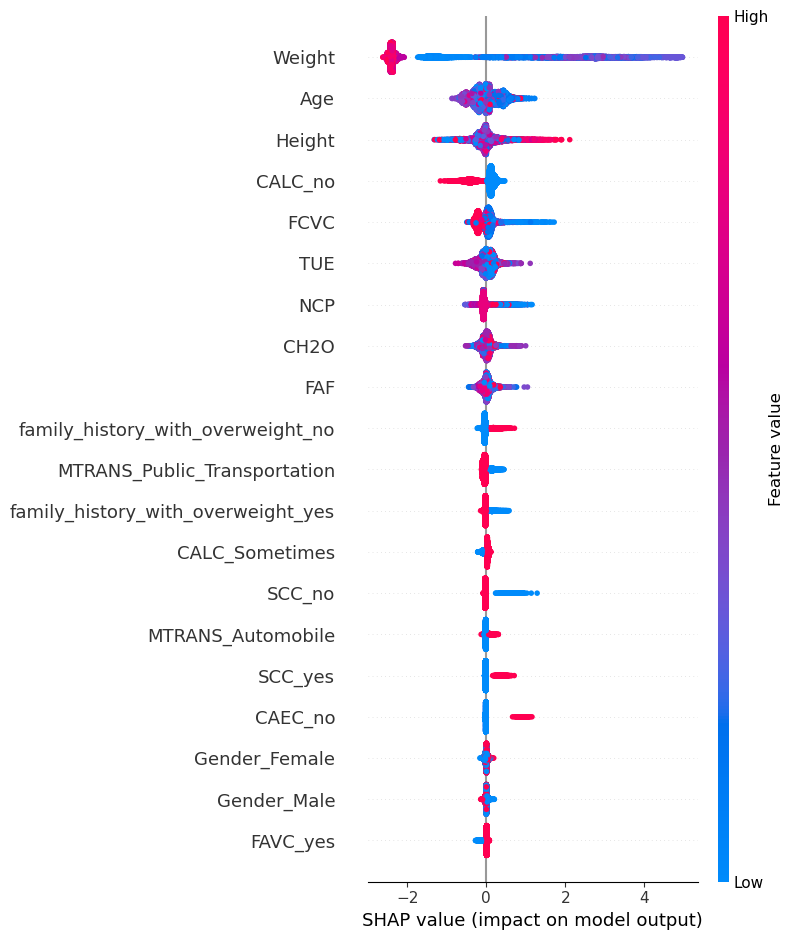

['Overweight_Level_II']


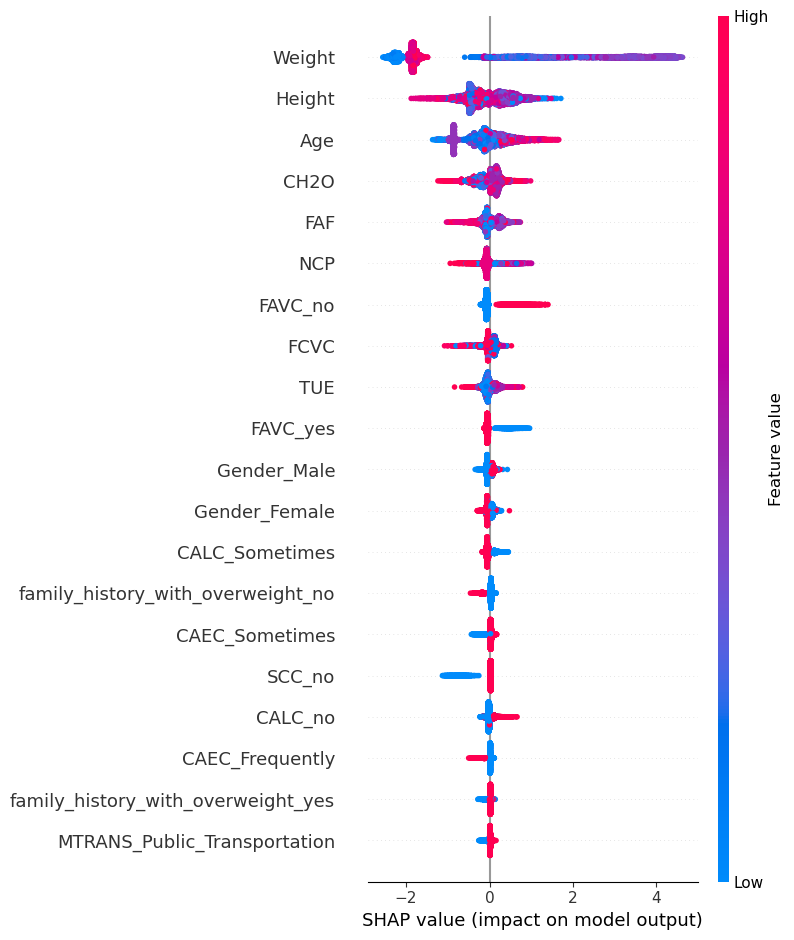

In [34]:
for x in range(len(shap_values)) : 
    print("="*50)
    print(le.inverse_transform([x]))
    shap.summary_plot(shap_values[x], pd.DataFrame(data=X_train,columns=X_train.columns)) #, plot_type=plot_type, show=False)

Threshold optimization

In [37]:
threshold_optimization = True
run_optuna_threshold = True

In [38]:
import optuna

def objective(trial):

    # Define the thresholds for each class
    thresholds = {}
    for i in range(num_classes):
        thresholds[f'threshold_{i}'] = trial.suggest_uniform(f'threshold_{i}', 0.0, 1.0)

    # Apply the thresholds to convert probabilities to predictions
    y_pred = apply_thresholds(y_pred_proba, thresholds)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy  

def apply_thresholds(y_proba, thresholds):
    # Apply the specified thresholds to convert probabilities to predicted labels
    y_pred_labels = np.argmax(y_proba, axis=1)
    for i in range(y_proba.shape[1]):
        y_pred_labels[y_proba[:, i] > thresholds[f'threshold_{i}']] = i

    return y_pred_labels

In [39]:
if run_optuna_threshold : 
    num_classes = 7
    y_pred_proba = y_pred_proba  # Example: replace with actual y_pred_proba
    y_val = y_val  # Example: replace with actual y_val

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=500)

    # Get the best thresholds
    best_thresholds = study.best_params
    print("Best Thresholds:", best_thresholds)
    print("Best Value:", study.best_value)
    threshold_optimization = True

[I 2024-04-21 14:11:58,595] A new study created in memory with name: no-name-277aca92-3e00-4360-b087-5ee46abd5e3a
[I 2024-04-21 14:11:58,669] Trial 0 finished with value: 0.9007039644312709 and parameters: {'threshold_0': 0.5498366489779771, 'threshold_1': 0.6042017429240846, 'threshold_2': 0.6034445004405496, 'threshold_3': 0.29869225109833275, 'threshold_4': 0.9351499267122496, 'threshold_5': 0.22612144063047523, 'threshold_6': 0.3581149564492284}. Best is trial 0 with value: 0.9007039644312709.
[I 2024-04-21 14:11:58,679] Trial 1 finished with value: 0.8721748795850315 and parameters: {'threshold_0': 0.15374597934443257, 'threshold_1': 0.8830838983866507, 'threshold_2': 0.24186450936006632, 'threshold_3': 0.5011403906338872, 'threshold_4': 0.7316368358679999, 'threshold_5': 0.9961113166331248, 'threshold_6': 0.10939815092943816}. Best is trial 0 with value: 0.9007039644312709.
[I 2024-04-21 14:11:58,695] Trial 2 finished with value: 0.8532789922193404 and parameters: {'threshold_0':

Best Thresholds: {'threshold_0': 0.4578427135126842, 'threshold_1': 0.6940184555354634, 'threshold_2': 0.29979967873896424, 'threshold_3': 0.7383143766672385, 'threshold_4': 0.9985308499941101, 'threshold_5': 0.414277415993026, 'threshold_6': 0.40394321772067593}
Best Value: 0.9088551315301964


In [40]:
if threshold_optimization : 
    if run_optuna_threshold == False : 
        best_thresholds = {'threshold_0': 0.724201213234911, 'threshold_1': 0.6161299800571379, 'threshold_2': 0.29138887902587174, 'threshold_3': 0.3145837593497076, 'threshold_4': 0.8469398340837189, 'threshold_5': 0.6800824438387787, 'threshold_6': 0.35886959729223455}


In [51]:
# y_test_label = lgb_model_final.predict(X_test)

# display(len(y_test_label))

# test['NObeyesdad'] = y_test_label
# out = test[['id','NObeyesdad']]
# out.NObeyesdad = le.inverse_transform(out.NObeyesdad)
# display(out.head(5))

# out.to_csv("submission_non_threshold_opt.csv",index=False)

# if threshold_optimization : 
    
#     y_test_label = lgb_model_final.predict_proba(X_test)
    
#     y_test_label = apply_thresholds(y_test_label, best_thresholds)

#     display(len(y_test_label))
    
#     test['NObeyesdad'] = y_test_label
#     out = test[['id','NObeyesdad']]
#     out.NObeyesdad = le.inverse_transform(out.NObeyesdad)
#     display(out.head(5))

#     out.to_csv("submission_threshold_opt.csv",index=False)

misclassifcaition investigation

In [42]:
feature_importance_df.head(5).Feature

1    Height
2    Weight
0       Age
6       FAF
5      CH2O
Name: Feature, dtype: object

In [43]:
temp = train.copy()

In [44]:
temp.shape[0]


13492

In [45]:
shap_values = plot_shap_summary(lgb_model_final, pd.DataFrame(data=temp.drop(target,axis=1),columns=temp.columns.drop(target)))

In [46]:
shap_magnitude = np.linalg.norm(shap_values,axis=2)
threshold = 6.5
outlier_mask = np.max(shap_magnitude, axis=0) > threshold

In [ ]:
# Use numpy's unique function to get unique values and their counts
unique_values, counts = np.unique(outlier_mask, return_counts=True)

# Combine unique values and counts into a dictionary
value_counts = dict(zip(unique_values, counts))

# Print the value counts
print(value_counts)

In [47]:
y_test_label = lgb_model_final.predict(temp.drop(target,axis=1))
temp['NObeyesdad_pred'] = y_test_label
temp['outlier_mask'] = outlier_mask
temp['miss_class'] = temp['NObeyesdad_pred']!=temp['NObeyesdad']
temp2 = temp[temp['miss_class']]
temp['outlier_mask']
temp3 = temp[temp['outlier_mask']]

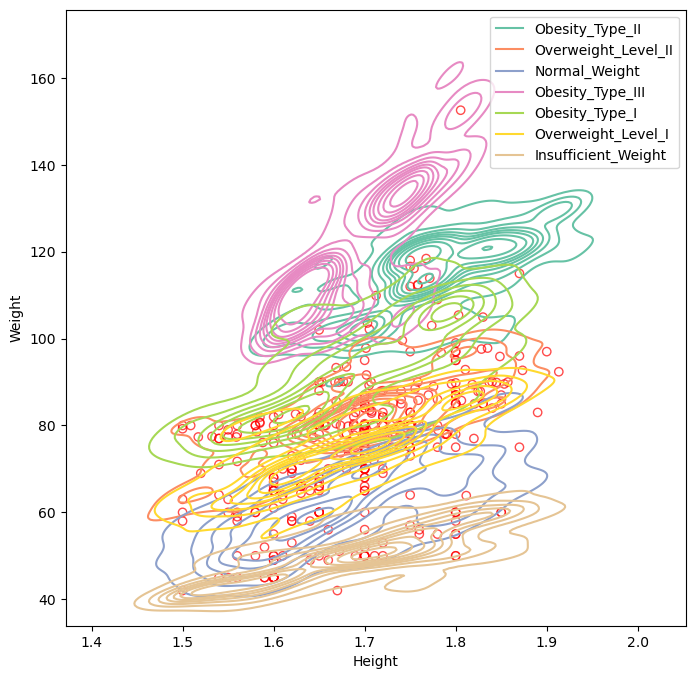

In [48]:
# First joint plot
plt.figure(figsize=(8, 8))

# Plot the main scatter plot
sns.kdeplot(x=temp.Height, y=temp.Weight, hue=le.inverse_transform(temp[target]), palette='Set2')

# Add the second set of points as red circles
sns.scatterplot(x='Height', y='Weight', data=temp2, color='red', edgecolor='red', marker='o', linewidth=1, alpha=0.7, facecolors='none')

plt.show()

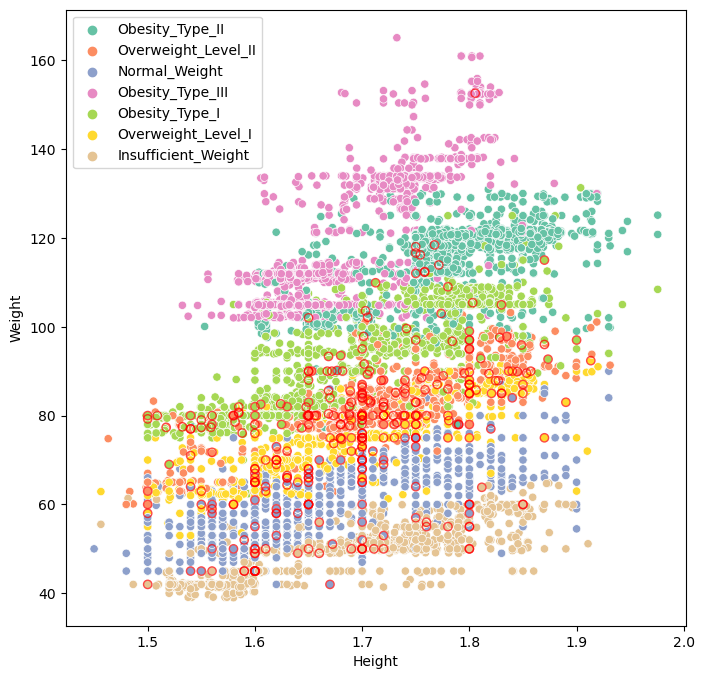

In [49]:
# First joint plot
plt.figure(figsize=(8, 8))

# Plot the main scatter plot
sns.scatterplot(x=temp.Height, y=temp.Weight, hue=le.inverse_transform(temp[target]), palette='Set2')

# Add the second set of points as red circles
sns.scatterplot(x='Height', y='Weight', data=temp2, color='red', edgecolor='red', marker='o', linewidth=1, alpha=0.7, facecolors='none')

plt.show()

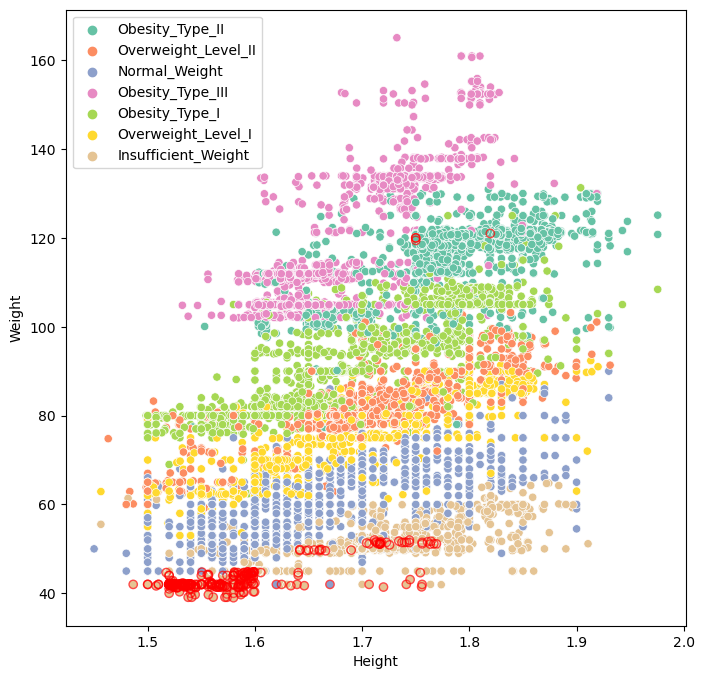

In [50]:
# First joint plot
plt.figure(figsize=(8, 8))

# Plot the main scatter plot
sns.scatterplot(x=temp.Height, y=temp.Weight, hue=le.inverse_transform(temp[target]), palette='Set2')

# Add the second set of points as red circles
sns.scatterplot(x='Height', y='Weight', data=temp3, color='red', edgecolor='red', marker='o', linewidth=1, alpha=0.7, facecolors='none')

plt.show()